### Libraries

In [1]:
# load packages
if (!require("BiocManager", quietly = TRUE))    install.packages("BiocManager")
if (!require("Rgraphviz", quietly = TRUE))      BiocManager::install(c("graph", "Rgraphviz", "gRain"))
if (!require("igraph", quietly = TRUE))         install.packages("igraph")
if (!require("tidyverse", quietly = TRUE))      install.packages("tidyverse")
if (!require("bnlearn", quietly = TRUE))        install.packages("bnlearn")
if (!require("DescTools", quietly = TRUE))      install.packages("DescTools")
if (!require("dplyr", quietly = TRUE))          install.packages("dplyr")
if (!require("infotheo", quietly = TRUE))       install.packages("infotheo")

library(infotheo)
library(tidyverse) |> suppressPackageStartupMessages()
library(bnlearn)   |> suppressPackageStartupMessages()
library(Rgraphviz) |> suppressPackageStartupMessages()
library(DescTools) |> suppressPackageStartupMessages()
library(igraph)
library(dplyr)


Bioconductor version '3.20' requires R version '4.4'; use `version = '3.18'`
  with R version 4.3; see https://bioconductor.org/install

Bioconductor version '3.20' is out-of-date; the current release version '3.21'
  is available with R version '4.5'; see https://bioconductor.org/install


Caricamento pacchetto: 'BiocGenerics'


I seguenti oggetti sono mascherati da 'package:stats':

    IQR, mad, sd, var, xtabs


I seguenti oggetti sono mascherati da 'package:base':

    Filter, Find, Map, Position, Reduce, anyDuplicated, aperm, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which.max, which.min



Caricamento pacchetto: 'igraph'


I seguenti oggetti sono mascherati da 'package:graph':

    degree, edges, intersection, u

### The K2 algorthm 

The K2 algorthm is a function that takes as an input: 
- The maximum number of parents a node can have 
- The dataset 
- The node ordering 

And provides as an output the DAG where the verticies are the nodes and the edges between nodes represent the condition probability between nodes. 

The K2 algorithm is a greedy algorithm that exploits a scoring function to find the most probable set of parents for each node. 
It compares the scorses achieved for each combination of {node, parents set} and assign the for each node the set of parents that maximizes that score. 


```
for i := 1 to n do

    π_i     := ∅
    P_old   := f(i, π_i)
    proceed := true

    while proceed and |π_i| < u do

        z     := node in Pred(x_i) - π_i that maximizes f(i, π_i ∪ {z})
        P_new := f(i, π_i ∪ {z})

        if P_new > P_old then

            P_old := P_new
            π_i   := π_i ∪ {z}

        else proceed := false

    end {while}

    write('Node:', x_i, 'Parents of this node:', π_i)
    
end {for}
```


In [2]:
k2 <- function(u, dataset, ordering = names(dataset)) {
    nodes <- ordering
    net.dag <- empty.graph(nodes = nodes)
    parent.list <- vector("list", length(nodes))
    names(parent.list) <- nodes
    score.log <- list()  

    for (i in seq_along(nodes)) {
        node <- nodes[i]
        if (i == 1) {
            prev.nodes <- character(0) # the first node has no parents
        } else {
            prev.nodes <- nodes[1:(i-1)] # nodes that precede the current node
        }
        parents <- character(0) 
        P_old <- f(node, parents, dataset)
        OK <- TRUE
        score.log[[node]] <- list()  # store scores for each node
        while (OK && length(parents) < u && length(prev.nodes) > 0) {
            scores <- sapply(prev.nodes, function(p) f(node, c(parents, p), dataset)) 
            
            score.log[[node]][[paste(sort(c(parents)), collapse = ",")]] <- setNames(as.list(scores), prev.nodes) # store scores for each parent for this node
            z <- prev.nodes[which.max(scores)] # best parent
            P_new <- max(scores) 
            if (P_new > P_old && z != node) { # if the new score is better than the old one and the best parent is not the node itself
                P_old <- P_new
                parents <- c(parents, z) # add the best parent to the list of parents
                prev.nodes <- setdiff(prev.nodes, z) # remove the best parent from the list of possible parents
                net.dag <- set.arc(net.dag, z, node) # add edge to the network
            } else {
                OK <- FALSE
            }
        }
        parent.list[[node]] <- parents
    }
    return(list(dag = net.dag, parents = parent.list, scores = score.log))  
}

### The score function f

The scoring function $f(i, \pi_i)$ is the probability of the database $D$ given that the set of parents of the variable $x_i$ is represented by the list of variables $\pi_i$.

$$
f(i, \pi_i) = \prod_{j=1}^{q_i} \frac{(r_i - 1)! \prod_{k=1}^{r_i} \alpha_{ijk}!}{(N_{ij} + r_i - 1)!} = \prod_{j=1}^{q_i} f_j
$$

where:

- $V_i =$ list of unique instantiations of $x_i$ relative to $D$
- $r_i = |V_i|$
- $\phi_i =$ list of unique instantiations of $\pi_i$ relative to $D$
- $q_i = |\phi_i|$
- $\alpha_{ijk} =$ # cases in $D$ in which $x_i$ is instantiated as the $k$-th element in $V_i$ and $\pi_i$ is instantiated as the $j$-th element in $\phi_i$
- $N_{ij} = \sum_{k=1}^{r_i} \alpha_{ijk} =$ # cases in $D$ in which $\pi_i$ is instantiated as the $j$-th element in $\phi_i$

In [3]:
f <- function(node, parents, dataset) {

    node.nunique <- dataset[node] |>
                        unique() |>
                        nrow()

    contingency_table <- dataset[c(node, parents)] |>
                            table() |>
                            as.data.frame() |>
                            as_tibble() |>
                            filter(Freq >= 0)

    numerator <- contingency_table |>
                    mutate(Freq = factorial(Freq)) |>
                    group_by_at(parents) |>
                    summarise(Freq = prod(Freq), .groups='drop_last') |>
                    mutate(Freq = (Freq * factorial(node.nunique - 1))) |>
                    ungroup() |>
                    select(Freq) |>
                    deframe()

    denominator <- contingency_table |>
                    group_by_at(parents) |>
                    summarise(Freq = sum(Freq), .groups='drop_last') |>
                    mutate(Freq = factorial(Freq + node.nunique - 1)) |>
                    ungroup() |>
                    select(Freq) |>
                    deframe()

    dataset.prob <- prod(numerator / denominator)

    return(dataset.prob)

}

### Score function in scale log 

It is possible to improve the run-time speed of the K2 algorithm by replacing $f$ with $\log(f)$.
In fact, the logarithmic version of the scoring function requires only addition and subtraction, rather than multiplication and division.

Note that:

$$
\log(n!) = \log \left( \prod_{x=1}^n x \right) = \sum_{x=1}^n \log(x)
$$

Therefore:

$$
\log(f) = \log \left( \prod_{j=1}^{q_i} f_j \right) = \sum_{j=1}^{q_i} \log(f_j)
$$

where:

$$
\begin{aligned}
\log(f_j) &= \log \left[ \frac{(r_i - 1)! \prod_{k=1}^{r_i} \alpha_{ijk}!}{(N_{ij} + r_i - 1)!} \right] = \newline
&= \log \left[ \left( r_i - 1 \right)! \right] + \log \left[ \prod_{k=1}^{r_i} \alpha_{ijk}! \right] - \log \left[ \left( N_{ij} + r_i - 1 \right)! \right] = \newline
&= \color{red}{\sum_{x=1}^{r_i - 1} \log(x)} + \color{green}{\sum_{k=1}^{r_i} \sum_{y=1}^{\alpha_{ijk}} \log(y)} - \color{blue}{\sum_{z=1}^{N_{ij} + r_i - 1} \log(z)} = \newline
&= \color{red}{A} + \color{green}{B} - \color{blue}{C}
\end{aligned}
$$

The use of $\log(f)$ as scoring function is particularly effective in the case of very large datasets, since it allows to avoid the computation of huge factorials.

In [4]:
f <- function(node, parents, dataset) { #log one 

    node.nunique <- dataset[node] |>
                        unique() |>
                        nrow()

    contingency_table <- dataset[c(node, parents)] |>
                            table() |>
                            as.data.frame() |>
                            as_tibble() |>
                            filter(Freq > 0)

    A <- 1:(node.nunique - 1) |>
            log() |>
            sum()

    B <- contingency_table |>
            rowwise() |>
            mutate(Freq = ((1:Freq) |> log() |> sum())) |>
            ungroup() |>
            group_by_at(parents) |>
            summarise(Freq = sum(Freq), .groups='drop_last') |>
            ungroup() |>
            select(Freq) |>
            deframe()

    C <- contingency_table |>
            group_by_at(parents) |>
            summarise(Freq = sum(Freq), .groups='drop_last') |>
            ungroup() |>
            rowwise() |>
            mutate(Freq = ((1:(Freq + node.nunique - 1)) |> log() |> sum())) |>
            ungroup() |>
            select(Freq) |>
            deframe()

    dataset.log.prob <- sum(A + B - C)
    
    return(dataset.log.prob)

}

### Mutual Information-Based Node Ordering Algorithm

The K2 algorithm is node order sensitive. That means that different node orders can give very different final DAGs. The best case scenario is when the ordering is given by an expert in the field we try to study. But often this task might be hard and time-consuming. For this reason, attempts have been made to extract the node ordering from the data itself. There are many methods to do so, mainly focused on extracting the node order using independence tests or scoring functions. 

Given that an exhaustive search is not computationally feasible, a common strategy is to get a set of random node orders and to pick the one that maximizes the overall score. We chose a different approach by using the mutual information between each node.

The following is the algorithm we used to get the node ordering that K2 needs to build the DAG. It is based on the 2008 paper *"Improving Bayesian Network Structure Learning with Mutual Information-Based Node Ordering in the K2 Algorithm"* by Xue-Wen Chen, Gopalakrishna Anantha, and Xiaotong Lin. The algorithm exploits the mutual information between each node and conditional independence tests to create an acyclic directed graph that has the nodes as vertices. The final node ordering to give to the K2 algorithm corresponds to the topological order of the previously mentioned directed graph.

The algorithm is divided into **4 main phases**:
- **Phase 1:** The algorithm calculates the mutual information of each node (with respect to any other node) and, for a pair of nodes (X,Y), if the condition $I(X;Y) \geq \alpha \times MMI(X)$ is satisfied, where $MMI(X)$ is the Maximum Mutual Information, then an edge is added between X and Y. We do so for each pair of nodes and in the end we will have an undirected network.
- **Phase 2:** The UDN we obtained from the previous phase might not be fully connected. We exploit the adjacency matrix properties to check the full connection and, if we find that the target or the source node is not connected to the network, or if the source node cannot reach the target, we add an edge to the network.
- **Phase 3:** In this phase the algorithm performs conditional independence tests to remove excess edges and refine the UDN.
- **Phase 4:** Finally, orientation is given to the graph. It uses conditional independence tests and BDe scores to assign orientation.

In [5]:
# The code to extract the node ordering from the dataset is divided in multiple functions.
# The main function is get_node_ordering_for_K2, which calls the other functions.
# The other functions are:
# - build_undirected_network: builds the undirected network
# - achieve_complete_connectivity: achieves complete connectivity
# - refine_graph_structure: refines the graph structure
# - assign_orientations: assigns orientations to the graph
# - extract_topological_order: extracts the topological order of the graph

# Main function to get node ordering for K2 algorithm
get_node_ordering_for_K2 <- function(data, alpha = 0.9, max_parents = NULL) {
  
  # Convert data to discrete numeric format
  data_discrete <- prepare_discrete_data(data)
  
  # PHASE 1: Build Undirected Network
  cat("PHASE 1: Building Undirected Network...\n")
  undirected_network <- build_undirected_network(data_discrete, alpha)
  
  # PHASE 2: Achieve Complete Connectivity
  cat("PHASE 2: Achieving Complete Connectivity...\n")
  complete_network <- achieve_complete_connectivity(undirected_network$adj_matrix, 
                                                   undirected_network$mi_matrix)
  
  # PHASE 3: Refine Graph Structure
  cat("PHASE 3: Refining Graph Structure...\n")
  refined_network <- refine_graph_structure(complete_network, data_discrete, 
                                          undirected_network$mi_matrix)
  
  # PHASE 4: Assign Orientations
  cat("PHASE 4: Assigning Orientations...\n")
  directed_network <- assign_orientations(refined_network, data_discrete)
  
  # Extract topological order
  node_order <- extract_topological_order(directed_network)
  
  return(node_order)
}

# Function to prepare discrete data
prepare_discrete_data <- function(data) {
  data_discrete <- data
  
  for (col in names(data)) {
    # If column is character or logical, convert to factor
    if (is.character(data[[col]]) || is.logical(data[[col]])) {
      data_discrete[[col]] <- as.factor(data[[col]])
    }
    # If numeric with few unique values, consider already discrete
    else if (is.numeric(data[[col]]) && length(unique(data[[col]])) < 20) {
      data_discrete[[col]] <- as.factor(data[[col]])
    }
    # Otherwise discretize using equal-width binning
    else {
      data_discrete[[col]] <- cut(data[[col]], breaks = 5, labels = FALSE)
    }
  }
  
  # Convert everything to numeric for MI calculation
  data_numeric <- as.data.frame(lapply(data_discrete, as.numeric))
  names(data_numeric) <- names(data)
  
  return(data_numeric)
}

### Phase 1: Creation of the Undirected Network

In the first phase we define the connection between nodes using the mutual information between them. The mutual information between two variables has the following expression: $I(X;Y) = H(X) - H(X|Y)$
where $H(X)$ is the Shannon entropy of X, in other words how much uncertainty there is in X. And $H(X|Y)$ is the conditional entropy, i.e., how much uncertainty there is in X given Y. The reason for using the mutual information between nodes to establish connections between them is that through MI we can evaluate how much the uncertainty in X changes given that we know Y: if there is a connection between X and Y it means that a lot of information is passed from X to Y.

From the practical point of view, we create an adjacency matrix where the vertices are the nodes, and a path is established when \. To avoid discarding existing connections ($\alpha$ too close to 1), or adding non-existent ones ($\alpha$ too low), we, as suggested in the reference, decided to use $\alpha = 0.9$.

In [6]:
# PHASE 1: Build Undirected Network
build_undirected_network <- function(data, alpha) {
  n_vars <- ncol(data)
  var_names <- names(data)
  
  # Calculate Mutual Information for all variable pairs
  mi_matrix <- matrix(0, n_vars, n_vars, dimnames = list(var_names, var_names))
  
  cat("Calculating Mutual Information...\n")
  for (i in 1:(n_vars-1)) {
    for (j in (i+1):n_vars) {
      # Calculate MI using infotheo library
      mi_value <- mutinformation(data[,i], data[,j])
      mi_matrix[i,j] <- mi_value
      mi_matrix[j,i] <- mi_value  # MI is symmetric
    }
  }
  # Find Maximum MI (MMI) for each node
  mmi <- apply(mi_matrix, 1, function(x) max(x[x > 0], na.rm = TRUE))
  
  # Build initial adjacency matrix
  adj_matrix <- matrix(0, n_vars, n_vars, dimnames = list(var_names, var_names))
  
  # Add edges
  cat("Building initial network...\n")
  for (i in 1:n_vars) {
    for (j in 1:n_vars) {
      if (i != j) {
        # Condition: I(X,Y) >= α * MMI(X) OR I(Y,X) >= α * MMI(Y)
        if (mi_matrix[i,j] >= alpha * mmi[i] || mi_matrix[j,i] >= alpha * mmi[j]) {
          adj_matrix[i,j] <- 1
          adj_matrix[j,i] <- 1
        }
      }
    }
  }
  
  return(list(adj_matrix = adj_matrix, mi_matrix = mi_matrix))
}




### Phase 2: Achieve Complete Connectivity
At this point, the UDN created in the previous section may not be fully connected. In this phase we exploit the adjacency matrix properties to find unconnected nodes and when one of the following conditions is met we add a connection:
- The target/source node is not connected to any other node in the network
- No path of any length exists that connects the source node with the target node

Let A be the adjacency matrix. If we raise it to the power of 2, for each entry i and j, $A_{ij}^2$ will represent the number of paths of length 2 between i and j. If we continue to raise the adjacency matrix until we reach n-1, and add all the matrices, we end up with a final matrix, the SUM_MATRIX. If in the matrix we spot a zero, it means that there are no paths of any length between those i and j.

In [7]:
# PHASE 2: Achieve Complete Connectivity
achieve_complete_connectivity <- function(adj_matrix, mi_matrix) {
  n_vars <- nrow(adj_matrix)
  var_names <- rownames(adj_matrix)
  
  # Create ordered list of node pairs by decreasing MI
  mi_pairs <- list()
  k <- 1
  for (i in 1:(n_vars-1)) {
    for (j in (i+1):n_vars) {
      mi_pairs[[k]] <- list(i = i, j = j, mi = mi_matrix[i,j])
      k <- k + 1
    }
  }
  mi_pairs <- mi_pairs[order(sapply(mi_pairs, function(x) x$mi), decreasing = TRUE)]
  
  # Check complete connectivity
  cat("Achieving complete connectivity...\n")
  while (!is_completely_connected(adj_matrix)) {
    # Add edges 
    for (pair in mi_pairs) {
      i <- pair$i
      j <- pair$j
      
      if (adj_matrix[i,j] == 0) {  # If edge doesn't exist yet
        # Check conditions to add edge
        # 1. Target node is not connected to any other node
        # 2. Source node is not connected to any other node  
        # 3. There's no path between source and target
        
        if (sum(adj_matrix[i,]) == 0 || sum(adj_matrix[j,]) == 0 ||
            !has_path(adj_matrix, i, j)) {
          adj_matrix[i,j] <- 1
          adj_matrix[j,i] <- 1
          
          # If now completely connected, exit
          if (is_completely_connected(adj_matrix)) {
            break
          }
        }
      }
    }
  }
  
  return(adj_matrix)
}

# Function to check if graph is completely connected
is_completely_connected <- function(adj_matrix) {
  if (nrow(adj_matrix) == 1) return(TRUE)
  g <- graph_from_adjacency_matrix(adj_matrix, mode = "undirected")
  return(is_connected(g))
}

# Function to check if path exists between two nodes
has_path <- function(adj_matrix, from, to) {
  if (from == to) return(TRUE)
  
  # Temporarily remove direct edge between nodes
  temp_adj <- adj_matrix
  temp_adj[from, to] <- 0
  temp_adj[to, from] <- 0
  
  g <- graph_from_adjacency_matrix(temp_adj, mode = "undirected")
  
  # If one node is isolated after removal, there's no path
  if (degree(g)[from] == 0 || degree(g)[to] == 0) {
    return(FALSE)
  }
  
  paths <- shortest_paths(g, from = from, to = to)
  return(length(paths$vpath[[1]]) > 0)
}

### Phase 3: Refine Graph Structure
In this phase we perform independence tests to eliminate or add connections. This consists of finding triangles in the UDN, let's say ABC, and eliminating an edge at a time, then performing an independence test on the opposite node from the edge we eliminated. If the independence test holds, the edge remains cancelled. If not, we eliminate another edge and perform another independence test.

For any triangle ABC:
- Eliminate A-B, test $P(A | C) = P(A | B, C)$
- Eliminate A-C, test $P(A | B) = P(A | C, B)$
- Eliminate B-C, test $P(B | A) = P(B | C, A)$

If the conditional independence test holds, we eliminate the edge from the UDN. If not, we keep searching for other parents from the MI list.

In [8]:
# PHASE 3: Refine Graph Structure
refine_graph_structure <- function(adj_matrix, data, mi_matrix) {
  n_vars <- nrow(adj_matrix)
  var_names <- rownames(adj_matrix)
  
  # Find all triangles in the graph
  triangles <- find_triangles(adj_matrix)
  
  cat(sprintf("Found %d triangles to refine...\n", length(triangles)))
  
  for (triangle in triangles) {
    # triangle contains indices of three nodes
    nodes <- triangle
    
    # Test conditional independence for each edge of the triangle
    edge_removed <- FALSE
    
    # Test for edge A-B conditioned on C
    if (test_conditional_independence(data, nodes[1], nodes[2], nodes[3])) {
      adj_matrix[nodes[1], nodes[2]] <- 0
      adj_matrix[nodes[2], nodes[1]] <- 0
      edge_removed <- TRUE
    }
    # Test for edge A-C conditioned on B
    else if (test_conditional_independence(data, nodes[1], nodes[3], nodes[2])) {
      adj_matrix[nodes[1], nodes[3]] <- 0
      adj_matrix[nodes[3], nodes[1]] <- 0
      edge_removed <- TRUE
    }
    # Test for edge B-C conditioned on A
    else if (test_conditional_independence(data, nodes[2], nodes[3], nodes[1])) {
      adj_matrix[nodes[2], nodes[3]] <- 0
      adj_matrix[nodes[3], nodes[2]] <- 0
      edge_removed <- TRUE
    }
    
    # If no test succeeds, try with potential parents 
    if (!edge_removed) {
      # For now keep the triangle
      # A complete implementation would search for common parents using MI
    }
  }
  
  return(adj_matrix)
}

# Function to find all triangles in the graph
find_triangles <- function(adj_matrix) {
  g <- graph_from_adjacency_matrix(adj_matrix, mode = "undirected")
  cliques <- cliques(g, min = 3, max = 3)
  return(lapply(cliques, as.numeric))
}

# Conditional independence test
test_conditional_independence <- function(data, x_idx, y_idx, z_idx) {
  # Get column names from indices
  var_names <- names(data)
  x_name <- var_names[x_idx]
  y_name <- var_names[y_idx]
  z_name <- var_names[z_idx]
  
  #we use simplified implementation based on conditional MI
  
  # Calculate MI(X,Y|Z)
  # If MI(X,Y|Z) ≈ 0, then X and Y are conditionally independent given Z
  
  # For simplicity, we use a threshold
  threshold <- 0.01
  
  # Calculate conditional mutual information
  xyz_data <- data[, c(x_idx, y_idx, z_idx)]
  
  # MI(X,Y|Z) using entropy
  mi_xy <- mutinformation(data[,x_idx], data[,y_idx])
  mi_xz <- mutinformation(data[,x_idx], data[,z_idx])
  mi_yz <- mutinformation(data[,y_idx], data[,z_idx])
  
  # Approximation: if MI(X,Y) << MI(X,Z) and MI(Y,Z), probably independent given Z
  cond_mi_approx <- mi_xy - min(mi_xz, mi_yz)
  
  return(cond_mi_approx < threshold)
}

### Phase 4: Assign Orientations
Finally, in this phase we give an orientation to the UDN. To do so we once again use the conditional independence test. We identify nodes (A, B) that are connected through only one node (C). Let's say:
A - C - B

We perform a conditional independence test between A and B given C: $P(A | C) = P(A | B, C)$, in other words, going from C to A is the same as going from B to C to A. If A and B are independent, B is not transferring any information to A.

If the test fails, it means that B is transferring information to A or the set of nodes {A, C, B} does not satisfy the Markov condition. So we search for other paths that connect A to B. If the potential set of parents (excluding C) for A and B is null, we assign the orientation A → C and B → C.

To keep things simple, we chose not to follow the remaining paper's steps to assign ordering (which consist of Scoring Four- and Five-Node Loops, Additional Conditional Independence Tests and Final Scoring Methods) but instead we order the remaining nodes avoiding cycles.

In [9]:
# PHASE 4: Assign Orientations
assign_orientations <- function(adj_matrix, data) {
  n_vars <- nrow(adj_matrix)
  
  # Create matrix for directed graph
  dag_matrix <- matrix(0, n_vars, n_vars, dimnames = list(rownames(adj_matrix), 
                                                          colnames(adj_matrix)))
  
  # PHASE 4: Conditional independence tests to assign some orientations
  dag_matrix <- phase4_conditional_independence(adj_matrix, dag_matrix, data)
  
  # PHASE 5-7: For simplicity, we orient remaining edges avoiding cycles
  dag_matrix <- complete_orientation(adj_matrix, dag_matrix)
  
  return(dag_matrix)
}

# PHASE 4: Conditional independence tests
phase4_conditional_independence <- function(adj_matrix, dag_matrix, data) {
  n_vars <- nrow(adj_matrix)
  
  cat("PHASE 4: Conditional independence tests...\n")
  
  for (c in 1:n_vars) {
    neighbors <- which(adj_matrix[c,] == 1)
    
    if (length(neighbors) >= 2) {
      for (i in 1:(length(neighbors)-1)) {
        for (j in (i+1):length(neighbors)) {
          a <- neighbors[i]
          b <- neighbors[j]
          
          # If A and B are not directly connected
          if (adj_matrix[a,b] == 0) {
            # If A and B are not conditionally independent given C
            if (!test_conditional_independence(data, a, b, c)) {
              # Orient A -> C and B -> C (v-structure)
              dag_matrix[a,c] <- 1
              dag_matrix[b,c] <- 1
            }
          }
        }
      }
    }
  }
  
  return(dag_matrix)
}

# Complete orientation of remaining edges
complete_orientation <- function(adj_matrix, dag_matrix) {
  cat("Completing orientations...\n")
  
  # Copy already oriented edges
  oriented_edges <- which(dag_matrix == 1, arr.ind = TRUE)
  
  # For each unoriented edge
  for (i in 1:nrow(adj_matrix)) {
    for (j in 1:ncol(adj_matrix)) {
      if (i != j && adj_matrix[i,j] == 1 && dag_matrix[i,j] == 0 && dag_matrix[j,i] == 0) {
        # Try to add edge i->j
        dag_matrix[i,j] <- 1
        
        # If creates cycle, try j->i instead
        if (has_cycle(dag_matrix)) {
          dag_matrix[i,j] <- 0
          dag_matrix[j,i] <- 1
          
          
          if (has_cycle(dag_matrix)) {
            dag_matrix[j,i] <- 0
            
          }
        }
      }
    }
  }
  
  return(dag_matrix)
}

# Function to check if graph has cycles
has_cycle <- function(dag_matrix) {
  if (sum(dag_matrix) == 0) return(FALSE)
  g <- graph_from_adjacency_matrix(dag_matrix, mode = "directed")
  return(!is_dag(g))
}

# Extract topological order 
extract_topological_order <- function(dag_matrix) {
  cat("Extracting topological order...\n")
  
  # If there are unoriented edges, orient them arbitrarily maintaining acyclicity
  adj_complete <- (dag_matrix + t(dag_matrix)) > 0
  
  for (i in 1:nrow(dag_matrix)) {
    for (j in 1:ncol(dag_matrix)) {
      if (i != j && adj_complete[i,j] && dag_matrix[i,j] == 0 && dag_matrix[j,i] == 0) {
        dag_matrix[i,j] <- 1
        if (has_cycle(dag_matrix)) {
          dag_matrix[i,j] <- 0
          dag_matrix[j,i] <- 1
        }
      }
    }
  }
  
  g <- graph_from_adjacency_matrix(dag_matrix, mode = "directed")
  
  # If graph is not a DAG, try to correct
  if (!is_dag(g)) {
    warning("Resulting graph is not a DAG. Attempting correction...")
    dag_matrix <- make_dag(dag_matrix)
    g <- graph_from_adjacency_matrix(dag_matrix, mode = "directed")
  }
  
  # Get topological order - USE topo_sort 
  topo_order <- topo_sort(g, mode = "out")
  node_names <- rownames(dag_matrix)
  
  return(node_names[topo_order])
}

# Utility function to make graph a DAG
make_dag <- function(dag_matrix) {
  max_iterations <- 100
  iter <- 0
  
  while (has_cycle(dag_matrix) && iter < max_iterations) {
    iter <- iter + 1
    g <- graph_from_adjacency_matrix(dag_matrix, mode = "directed")
    
    # Find a simple cycle
    # Use DFS to find back edges
    for (i in 1:nrow(dag_matrix)) {
      for (j in 1:ncol(dag_matrix)) {
        if (dag_matrix[i,j] == 1) {
          # Temporarily remove this edge
          dag_matrix[i,j] <- 0
          
          # If now has no cycles, keep the removal
          if (!has_cycle(dag_matrix)) {
            break
          } else {
            # otherwise restore
            dag_matrix[i,j] <- 1
          }
        }
      }
      if (!has_cycle(dag_matrix)) break
    }
  }
  
  if (iter == max_iterations) {
    warning("Unable to remove all cycles")
  }
  
  return(dag_matrix)
}



# Testing 
Now we want to test the K2 and Ordering algorithms on 4 datasets. 
- Ruiz dataset
- Asia dataset
- Child dataset
- Sachs dataset

### Testing: dummy dataset

In [10]:
# Test on dummy data
dummy <- data.frame(
  x1 = c(1,1,0,1,0,0,1,0,1,0),
  x2 = c(0,1,0,1,0,1,1,0,1,0),
  x3 = c(0,1,1,1,0,1,1,0,1,0)
)

# Run the algorithm
node_order <- get_node_ordering_for_K2(dummy, alpha = 0.7)
print(node_order)


PHASE 1: Building Undirected Network...
Calculating Mutual Information...
Building initial network...
PHASE 2: Achieving Complete Connectivity...
Achieving complete connectivity...
PHASE 3: Refining Graph Structure...
Found 0 triangles to refine...
PHASE 4: Assigning Orientations...
PHASE 4: Conditional independence tests...
Completing orientations...
Extracting topological order...
[1] "x1" "x2" "x3"



  Random/Generated Bayesian network

  model:
   [x1][x2|x1][x3|x2] 
  nodes:                                 3 
  arcs:                                  2 
    undirected arcs:                     0 
    directed arcs:                       2 
  average markov blanket size:           1.33 
  average neighbourhood size:            1.33 
  average branching factor:              0.67 

  generation algorithm:                  Empty 


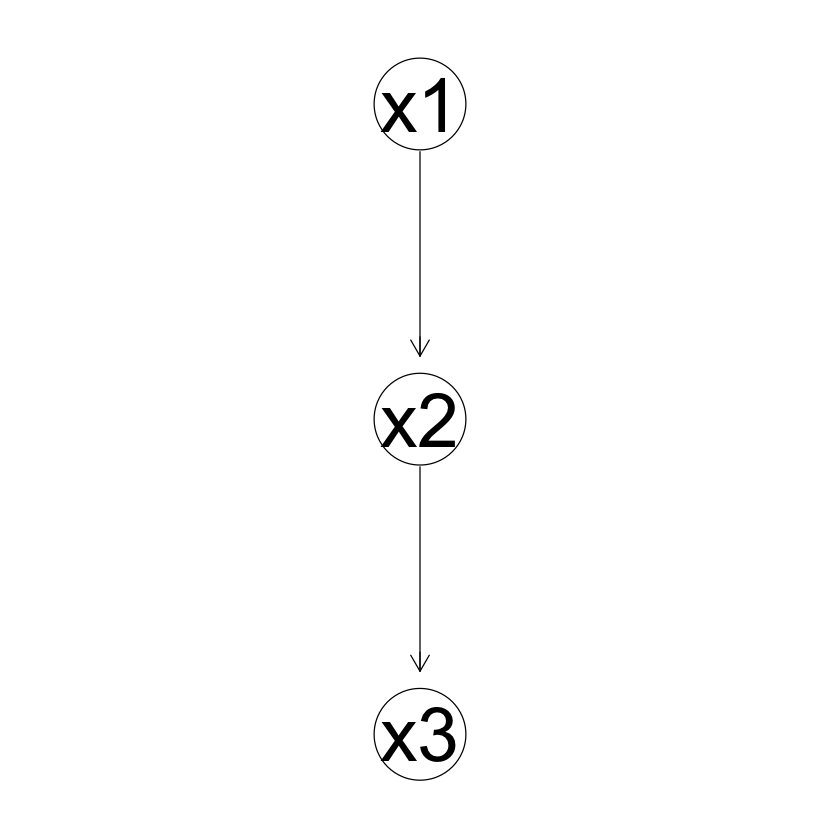

In [11]:
result <- k2(2, dummy, ordering = node_order )
result$dag
graphviz.plot(result$dag)

### Test: Asia Dataset

In [12]:
asia <- read_csv('https://www.ccd.pitt.edu/wiki/images/ASIA10k.csv')
head(asia)

Rows: 10000 Columns: 8
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (8): asia, tub, smoke, lung, bronc, either, xray, dysp

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


asia,tub,smoke,lung,bronc,either,xray,dysp
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
no,no,no,no,no,no,no,yes
no,no,yes,no,no,no,no,no
no,no,no,no,no,no,no,no
no,no,yes,no,no,no,no,no
no,no,yes,no,yes,no,no,yes
no,no,yes,no,no,no,no,no


PHASE 1: Building Undirected Network...
Calculating Mutual Information...
Building initial network...
PHASE 2: Achieving Complete Connectivity...
Achieving complete connectivity...


Warning message in shortest_paths(g, from = from, to = to):
"At vendor/cigraph/src/paths/unweighted.c:444 : Couldn't reach some vertices."


PHASE 3: Refining Graph Structure...
Found 0 triangles to refine...
PHASE 4: Assigning Orientations...
PHASE 4: Conditional independence tests...
Completing orientations...
Extracting topological order...


   utente   sistema trascorso 
    1.354     0.032     1.446 


  Random/Generated Bayesian network

  model:
   [asia][smoke][tub][lung|smoke][bronc|smoke][either|tub:lung]
   [dysp|bronc:either][xray|either]
  nodes:                                 8 
  arcs:                                  7 
    undirected arcs:                     0 
    directed arcs:                       7 
  average markov blanket size:           2.25 
  average neighbourhood size:            1.75 
  average branching factor:              0.88 

  generation algorithm:                  Empty 


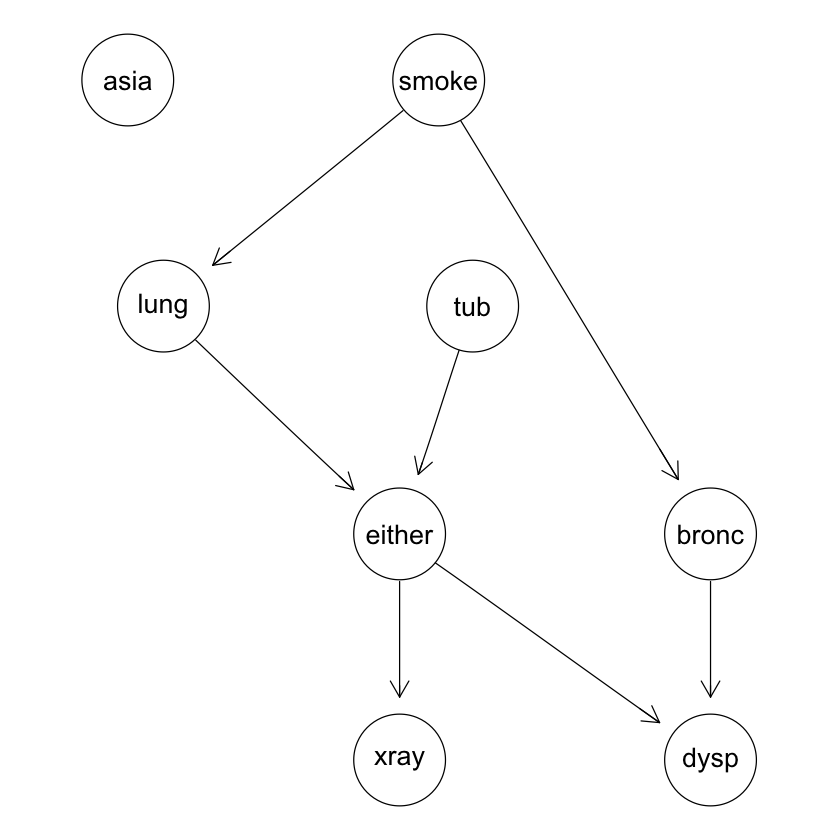

In [13]:
system.time({
asia_order <- get_node_ordering_for_K2(asia, alpha = 0.9)
asia_net <- k2(ncol(asia) - 1, asia, asia_order)
})
asia_net$dag
graphviz.plot(asia_net$dag)


In [14]:
sachs <- read_csv('https://www.ccd.pitt.edu/wiki/images/SACHS10k.csv')
sachs <- sachs |> select(PKC, Plcg, PKA, PIP3, Raf, Jnk, P38, PIP2, Mek, Erk, Akt)

head(sachs)

Rows: 10000 Columns: 11
-- Column specification --------------------------------------------------------
Delimiter: ","
dbl (11): Akt, Erk, Jnk, Mek, P38, PIP2, PIP3, PKA, PKC, Plcg, Raf

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


PKC,Plcg,PKA,PIP3,Raf,Jnk,P38,PIP2,Mek,Erk,Akt
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,1,2,2,1,1,1,1,1,1,1
2,1,2,2,1,1,2,1,1,2,1
1,3,1,2,3,3,3,2,1,1,1
1,1,3,3,2,1,1,1,1,2,1
2,2,2,3,1,1,1,1,1,2,1
2,1,2,1,2,2,1,1,2,2,1


PHASE 1: Building Undirected Network...
Calculating Mutual Information...
Building initial network...
PHASE 2: Achieving Complete Connectivity...
Achieving complete connectivity...


Warning message in shortest_paths(g, from = from, to = to):
"At vendor/cigraph/src/paths/unweighted.c:444 : Couldn't reach some vertices."
Warning message in shortest_paths(g, from = from, to = to):
"At vendor/cigraph/src/paths/unweighted.c:444 : Couldn't reach some vertices."


PHASE 3: Refining Graph Structure...
Found 0 triangles to refine...
PHASE 4: Assigning Orientations...
PHASE 4: Conditional independence tests...
Completing orientations...
Extracting topological order...


   utente   sistema trascorso 
    8.804     0.093     8.962 


  Random/Generated Bayesian network

  model:
   [PKC][Plcg][Raf|PKC][PIP3|Plcg][Erk|PKC:Raf][PIP2|Plcg:PIP3][PKA|PKC:Raf:Erk]
   [Jnk|PKC:PKA][P38|PKC:PKA][Mek|PKC:Raf:Erk:PKA][Akt|Erk:PKA]
  nodes:                                 11 
  arcs:                                  19 
    undirected arcs:                     0 
    directed arcs:                       19 
  average markov blanket size:           3.45 
  average neighbourhood size:            3.45 
  average branching factor:              1.73 

  generation algorithm:                  Empty 


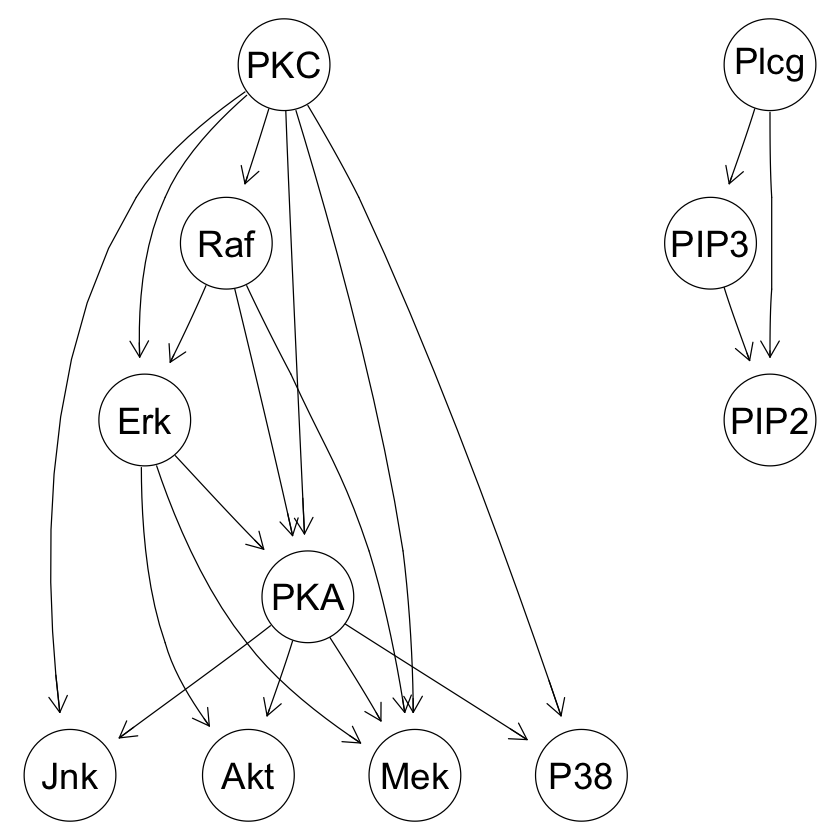

In [15]:
system.time({
sachs_order <- get_node_ordering_for_K2(sachs, alpha = 0.9)
sachs_net <- k2(ncol(sachs) - 1, sachs, sachs_order)
})
sachs_net$dag
graphviz.plot(sachs_net$dag)

In [16]:
child <- read_csv('https://www.ccd.pitt.edu/wiki/images/CHILD10k.csv')
child <- child |> select(BirthAsphyxia, Disease, Sick, DuctFlow, CardiacMixing, LungParench, LungFlow, LVH, Age, Grunting, HypDistrib, HypoxiaInO2, CO2, ChestXray, LVHreport, GruntingReport, LowerBodyO2, RUQO2, CO2Report, XrayReport)

head(child)

Rows: 10000 Columns: 20
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (20): BirthAsphyxia, HypDistrib, HypoxiaInO2, CO2, ChestXray, Grunting, ...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


BirthAsphyxia,Disease,Sick,DuctFlow,CardiacMixing,LungParench,LungFlow,LVH,Age,Grunting,HypDistrib,HypoxiaInO2,CO2,ChestXray,LVHreport,GruntingReport,LowerBodyO2,RUQO2,CO2Report,XrayReport
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
no,PAIVS,yes,Lt_to_Rt,Complete,Normal,Low,no,0-3_days,no,Equal,Moderate,Normal,Oligaemic,no,no,5-12,5-12,>=7.5,Grd_Glass
no,TGA,yes,None,Transp.,Abnormal,Low,no,0-3_days,yes,Equal,Severe,Normal,Asy/Patch,no,no,12+,<5,<7.5,Asy/Patchy
no,TGA,yes,None,Transp.,Normal,High,yes,0-3_days,no,Equal,Severe,Normal,Normal,yes,no,12+,5-12,<7.5,Normal
no,Lung,yes,None,Mild,Abnormal,Normal,no,0-3_days,yes,Equal,Moderate,Normal,Asy/Patch,no,yes,5-12,5-12,>=7.5,Asy/Patchy
no,Fallot,no,Lt_to_Rt,Complete,Normal,Low,no,4-10_days,no,Equal,Moderate,Normal,Normal,no,no,5-12,5-12,<7.5,Normal
no,Fallot,no,Lt_to_Rt,Mild,Normal,Low,no,4-10_days,no,Equal,Moderate,Normal,Oligaemic,no,yes,5-12,<5,<7.5,Oligaemic


PHASE 1: Building Undirected Network...
Calculating Mutual Information...
Building initial network...
PHASE 2: Achieving Complete Connectivity...
Achieving complete connectivity...


Warning message in shortest_paths(g, from = from, to = to):
"At vendor/cigraph/src/paths/unweighted.c:444 : Couldn't reach some vertices."
Warning message in shortest_paths(g, from = from, to = to):
"At vendor/cigraph/src/paths/unweighted.c:444 : Couldn't reach some vertices."
Warning message in shortest_paths(g, from = from, to = to):
"At vendor/cigraph/src/paths/unweighted.c:444 : Couldn't reach some vertices."


PHASE 3: Refining Graph Structure...
Found 0 triangles to refine...
PHASE 4: Assigning Orientations...
PHASE 4: Conditional independence tests...
Completing orientations...
Extracting topological order...


   utente   sistema trascorso 
    9.838     0.135    10.146 


  Random/Generated Bayesian network

  model:
   [BirthAsphyxia][LungParench][Disease|BirthAsphyxia:LungParench]
   [Grunting|LungParench][CO2|LungParench][Sick|LungParench:Disease:Grunting]
   [DuctFlow|Disease][CardiacMixing|Disease][LungFlow|Disease][LVH|Disease]
   [GruntingReport|Grunting][CO2Report|CO2][Age|Disease:Sick]
   [HypDistrib|DuctFlow:CardiacMixing][HypoxiaInO2|LungParench:CardiacMixing]
   [ChestXray|LungParench:LungFlow][LVHreport|LVH]
   [LowerBodyO2|HypDistrib:HypoxiaInO2][RUQO2|HypoxiaInO2][XrayReport|ChestXray]
  nodes:                                 20 
  arcs:                                  26 
    undirected arcs:                     0 
    directed arcs:                       26 
  average markov blanket size:           3.20 
  average neighbourhood size:            2.60 
  average branching factor:              1.30 

  generation algorithm:                  Empty 


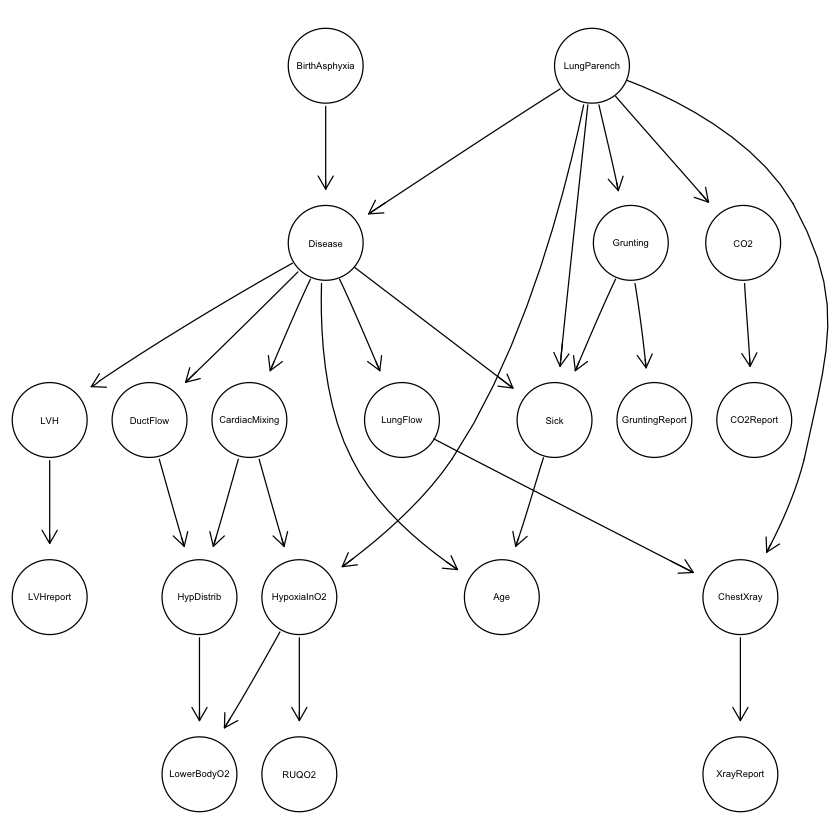

In [17]:
system.time({
child_order <- get_node_ordering_for_K2(child, alpha = 0.9)
child_net <- k2(ncol(child) - 1, child, child_order)
})
child_net$dag
graphviz.plot(child_net$dag)